In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [2]:
def generate_sine_wave(seq_length, num_sequences, frequency=1, amplitude=1):
    x = np.linspace(0, 2 * np.pi * frequency, seq_length)
    data = np.array([amplitude * np.sin(x) for _ in range(num_sequences)])
    return data

seq_length = 100
num_sequences = 1000
sine_wave_data = generate_sine_wave(seq_length, num_sequences)


In [3]:
def prepare_data(data, window_size, prediction_horizon):
    X, y = [], []
    for seq in data:
        for i in range(len(seq) - window_size - prediction_horizon):
            X.append(seq[i:i + window_size])
            y.append(seq[i + window_size:i + window_size + prediction_horizon])
    return np.array(X), np.array(y)

window_size = 30
prediction_horizon = 10
X, y = prepare_data(sine_wave_data, window_size, prediction_horizon)


In [4]:
def create_encoder(input_shape):
    input_seq = Input(shape=input_shape)
    x = Reshape((input_shape[0], input_shape[1], 1))(input_seq)  # Add channel dimension
    x = Conv2D(32, (3, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 1))(x)
    x = Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 1))(x)
    x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 1))(x)
    x = Reshape((-1, 128))(x)  # Reshape to (batch, new_time_steps, 128)
    encoded = LayerNormalization()(x)  # Normalizing the latent vectors
    return Model(input_seq, encoded)

encoder = create_encoder((window_size, 1))


In [5]:
# Autoregressive model
def create_autoregressive_model(input_shape):
    input_latents = Input(shape=input_shape)
    context = LSTM(128, return_sequences=True)(input_latents)
    return Model(input_latents, context)

ar_model = create_autoregressive_model((window_size // 8, 128))  # Adjust time steps according to pooling

# InfoNCE loss function
def infonce_loss(context, positive, negatives):
    context = K.l2_normalize(context, axis=-1)
    positive = K.l2_normalize(positive, axis=-1)
    negatives = K.l2_normalize(negatives, axis=-1)
    
    positive_score = K.sum(context * positive, axis=-1, keepdims=True)
    negative_scores = K.sum(context[:, None, :] * negatives, axis=-1)
    
    # Ensure the shapes are aligned for concatenation
    batch_size = K.shape(positive_score)[0]
    positive_score = K.reshape(positive_score, [batch_size, -1])
    negative_scores = K.reshape(negative_scores, [batch_size, -1])
    
    logits = K.concatenate([positive_score, negative_scores], axis=-1)
    labels = tf.zeros((batch_size,), dtype=tf.int32)  # Create labels with shape (batch_size,)
    
    return K.mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

# Custom training step to generate positive and negative samples
class CPCModel(Model):
    def __init__(self, encoder, ar_model, **kwargs):
        super(CPCModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.ar_model = ar_model

    def call(self, inputs):
        latents = self.encoder(inputs)
        context = self.ar_model(latents)
        return context

    def train_step(self, data):
        inputs, _ = data
        with tf.GradientTape() as tape:
            latents = self.encoder(inputs)
            context = self.ar_model(latents)

            # Positive samples are the next latent vectors
            positive_samples = latents[:, 1:, :]
            context = context[:, :-1, :]

            # Negative samples are shuffled versions of the positive samples
            batch_size, time_steps, latent_dim = positive_samples.shape
            negatives = tf.reshape(positive_samples, [-1, latent_dim])
            negatives = tf.random.shuffle(negatives)
            negatives = tf.reshape(negatives, [batch_size, time_steps, latent_dim])

            loss = infonce_loss(context, positive_samples, negatives)

            # Add the custom loss to the model's losses
            self.add_loss(loss)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(self.losses, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

cpc_model = CPCModel(encoder, ar_model)
cpc_model.compile(optimizer=Adam(), loss=lambda y_true, y_pred: 0)  # Dummy loss

In [7]:
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape to (batch, time_steps, features)
y = np.zeros_like(X)  # Dummy y because we're using a custom training loop

cpc_model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8901 - val_loss: 0.0000e+00
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.8627 - val_loss: 0.0000e+00
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8578 - val_loss: 0.0000e+00
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8788 - val_loss: 0.0000e+00
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.8511 - val_loss: 0.0000e+00
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8461 - val_loss: 0.0000e+00
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8600 - val_loss: 0.0000e+00
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.8393 - val_loss: 0.0000e+00
Epoch 9/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8243 - val_loss: 0.0000e+00
Epoch 10/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.8258 - val_loss: 0.0000e+00
Epoch 11/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.8261 - val_loss: 0.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

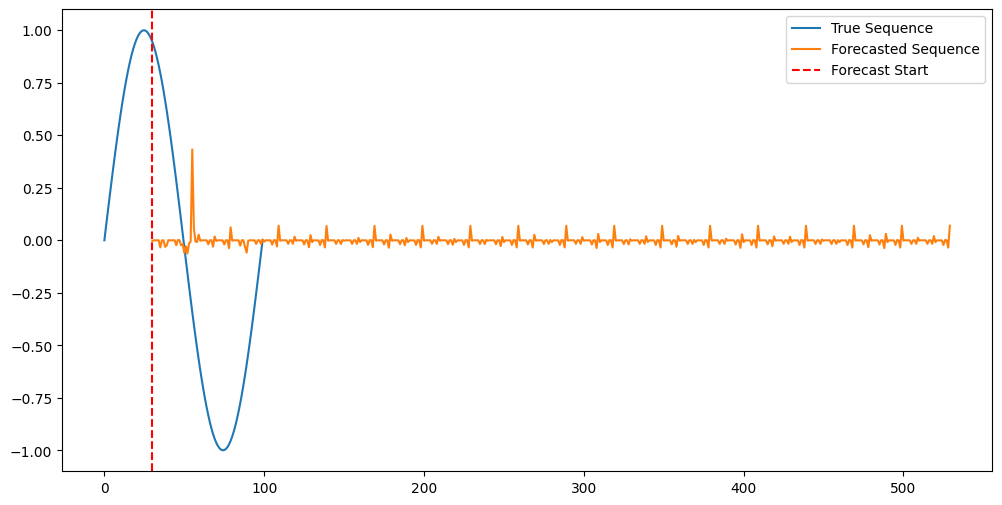

In [8]:
def forecast_and_plot(encoder, ar_model, input_sequence, steps, prediction_horizon, true_sequence):
    input_sequence = input_sequence.reshape(1, -1, 1)  # Reshape to (batch, time_steps, features)
    latent_seq = encoder.predict(input_sequence)
    context = ar_model.predict(latent_seq)
    forecasted_sequence = []
    
    current_input = input_sequence
    for _ in range(steps):
        latent_seq = encoder.predict(current_input)
        context = ar_model.predict(latent_seq)
        prediction = context[:, -prediction_horizon:, :].flatten()[:prediction_horizon]  # Ensure correct prediction size
        forecasted_sequence.extend(prediction)
        current_input = np.roll(current_input, -prediction_horizon, axis=1)
        current_input[:, -prediction_horizon:, :] = prediction.reshape(1, -1, 1)
    
    forecasted_sequence = np.array(forecasted_sequence)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(true_sequence)), true_sequence, label='True Sequence')
    plt.plot(range(len(input_sequence.flatten()), len(input_sequence.flatten()) + len(forecasted_sequence)), forecasted_sequence, label='Forecasted Sequence')
    plt.axvline(x=len(input_sequence.flatten()), color='r', linestyle='--', label='Forecast Start')
    plt.legend()
    plt.show()
    
    return forecasted_sequence

# Example forecast
new_sequence = generate_sine_wave(seq_length, 1).reshape(-1)
input_sequence = new_sequence[:window_size]
true_sequence = new_sequence[:window_size + 50 * prediction_horizon]
forecasted_values = forecast_and_plot(encoder, ar_model, input_sequence, steps=50, prediction_horizon=prediction_horizon, true_sequence=true_sequence)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
# Generate sine wave data
def generate_sine_wave(num_samples):
    x = np.linspace(0, 1000, num_samples)
    y = np.sin(x)
    return y

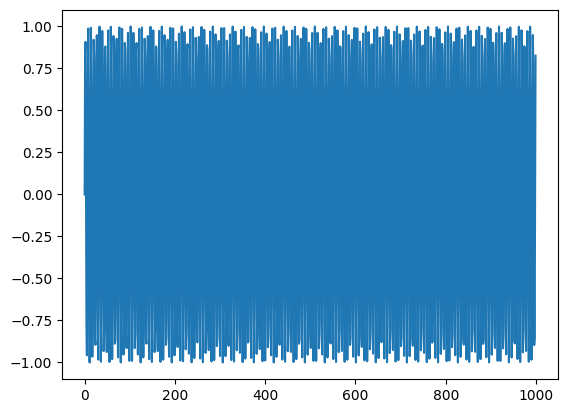

In [ ]:
data = generate_sine_wave(1_000)
plt.plot(data)

In [ ]:
# Create sequences and targets using a sliding window approach
def create_windows(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + 1:i + seq_length + 1])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 10

In [ ]:
X, y = create_windows(data, seq_length)
print(X.shape, y.shape)

(990, 10) (990, 10)


In [ ]:
# Reshape to match the shape expected by LSTM layers
X = X[..., np.newaxis]
y = y[..., np.newaxis]

# Split sequentially into training, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [ ]:
# # Plot the first sequence in X_train and the corresponding sequence in y_train
# plt.figure(figsize=(14, 7))
# plt.plot(range(seq_length), X_train[0, :, 0], label='X_train (Input Sequence)', color='b')
# plt.plot(range(seq_length, 2 * seq_length), y_train[0, :, 0], label='y_train (True Future)', color='orange')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.title('X_train and y_train Sequences')
# plt.legend()
# plt.show()


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((693, 10, 1),
 (693, 10, 1),
 (148, 10, 1),
 (148, 10, 1),
 (149, 10, 1),
 (149, 10, 1))

In [ ]:
def td_infonce_loss(gamma=0.99):
    def loss(y_true, y_pred):
        batch_size = tf.shape(y_pred)[0]
        seq_length = tf.shape(y_pred)[1]
        feature_dim = tf.shape(y_pred)[2]

        y_true_flat = tf.reshape(y_true, [batch_size, seq_length * feature_dim])
        y_pred_flat = tf.reshape(y_pred, [batch_size, seq_length * feature_dim])

        y_true_norm = tf.nn.l2_normalize(y_true_flat, axis=-1)
        y_pred_norm = tf.nn.l2_normalize(y_pred_flat, axis=-1)

        similarity_matrix = tf.matmul(y_pred_norm, y_true_norm, transpose_b=True)
        labels = tf.one_hot(tf.range(batch_size), batch_size)

        loss_term1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, similarity_matrix))

        w = tf.exp(similarity_matrix) / tf.reduce_sum(tf.exp(similarity_matrix), axis=-1, keepdims=True)
        w = tf.stop_gradient(w)

        loss_term2 = tf.reduce_mean(w * tf.nn.softmax_cross_entropy_with_logits(labels, similarity_matrix))

        return (1 - gamma) * loss_term1 + gamma * loss_term2
    return loss


In [ ]:
def create_cdpc_model(seq_length, feature_dim, latent_dim):
    # Encoder
    input_seq = Input(shape=(seq_length, feature_dim))
    encoded = LSTM(latent_dim, return_sequences=True)(input_seq)
    encoded = LSTM(latent_dim)(encoded)

    # Context Network
    context = Dense(latent_dim, activation='relu')(encoded)
    context = Dense(latent_dim, activation='relu')(context)

    # Prediction of future values
    future_values = Dense(seq_length * feature_dim)(context)
    future_values = Lambda(lambda x: K.reshape(x, (-1, seq_length, feature_dim)))(future_values)

    # Model
    model = Model(inputs=input_seq, outputs=future_values)
    return model

feature_dim = 1
latent_dim = 128

model = create_cdpc_model(seq_length, feature_dim, latent_dim)
model.compile(optimizer=Adam(learning_rate=0.001), loss=td_infonce_loss())
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 10, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,458 (908.04 KB)

 Trainable params: 232,458 (908.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1232 - val_loss: 0.1140
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1122 - val_loss: 0.1141
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1119 - val_loss: 0.1146
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1119 - val_loss: 0.1139
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1128 - val_loss: 0.1138
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1119 - val_loss: 0.1138
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1125 - val_loss: 0.1137
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1120 - val_loss: 0.1137
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1126 - val_loss: 0.1138


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

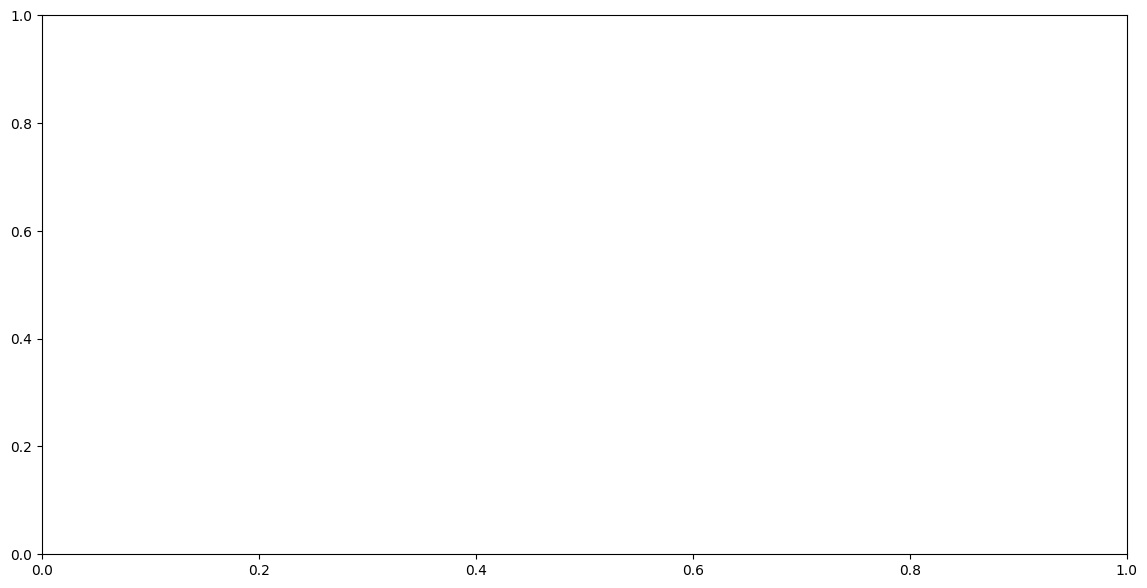

In [ ]:
# Predict on training data
pred_values = model.predict(X_train)

# Plot results for a single sample from the training data
plt.figure(figsize=(14, 7))
plt.plot(range(50), X_train[0, :, 0], label='Input Sequence')
plt.plot(range(50, 100), y_train[0, :, 0], label='True Future')
plt.plot(range(50, 100), pred_values[0, :, 0], label='Predicted Future')
plt.legend()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

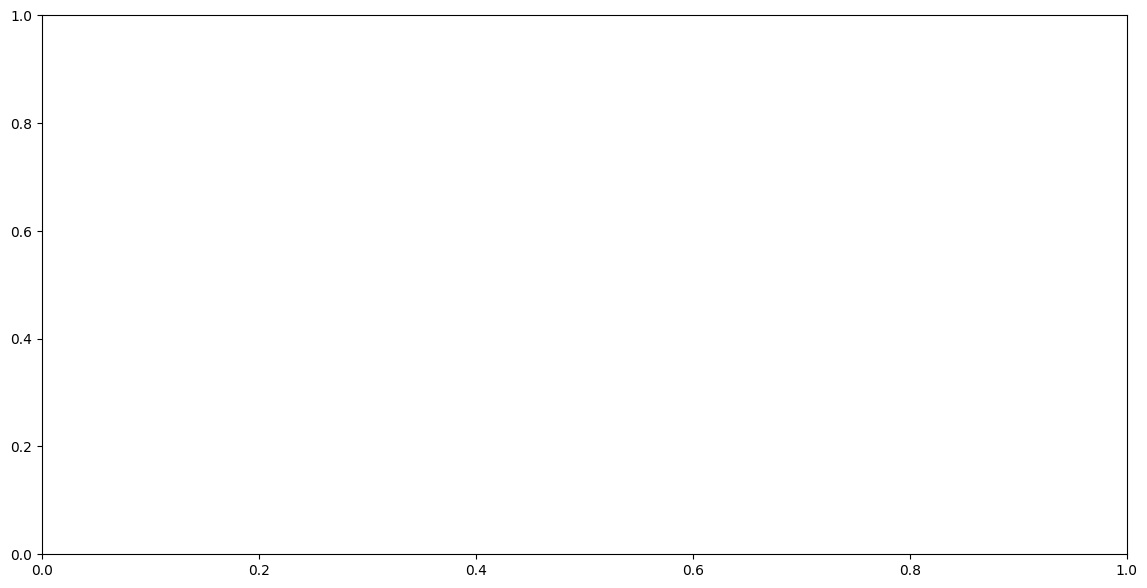

In [ ]:
# Predict on test data
pred_test_values = model.predict(X_test)
# Plot results for a single sample from the test data
plt.figure(figsize=(14, 7))
plt.plot(range(50), X_test[0, :, 0], label='Input Sequence')
plt.plot(range(50, 100), y_test[0, :, 0], label='True Future')
plt.plot(range(50, 100), pred_test_values[0, :, 0], label='Predicted Future')
plt.legend()
plt.show()